# ToDo
 - ___[DONE]___ 重要度のランキング
 - ___[DONE]___ 重要度の偏りがないかの確認（sns.distplot）

In [73]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from logging import StreamHandler, DEBUG, Formatter, FileHandler, getLogger
logger = getLogger(__name__)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import log_loss, roc_auc_score
import lightgbm as lgb
import optuna

from LoadDate import loadTrainData, loadTestData

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [70]:
df.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
xTrain = df.drop('target', axis=1)
yTrain = df['target'].values

In [61]:
xTrain.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
1,9,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
2,13,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
3,16,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [62]:
yTrain

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [63]:
params = {
    'learning_rate': 0.005,
    'n_estimators': 40,
    'num_leaves': 6,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'random_state': 501,  # Updated from 'seed'
    'colsample_bytree': 0.65,
    'subsample': 0.7,
    'reg_alpha': 1,
    'reg_lambda': 1
    }

In [64]:
clf = lgb.LGBMClassifier(**params)

In [65]:
clf.fit(xTrain, yTrain)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.65,
        importance_type='split', learning_rate=0.005, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=40, n_jobs=-1, num_leaves=6, objective='binary',
        random_state=501, reg_alpha=1, reg_lambda=1, silent=True,
        subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

In [66]:
# np.argsortで昇順にインデックスが返ってくる
np.argsort(clf.feature_importances_)

array([ 0, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 29, 56, 57, 26,  1,  2,  4,  8,
       10, 11, 12, 27, 14, 15, 13, 18, 19, 22, 23,  9, 20,  7, 25, 16,  6,
       24,  3, 28, 21, 17,  5, 35], dtype=int64)

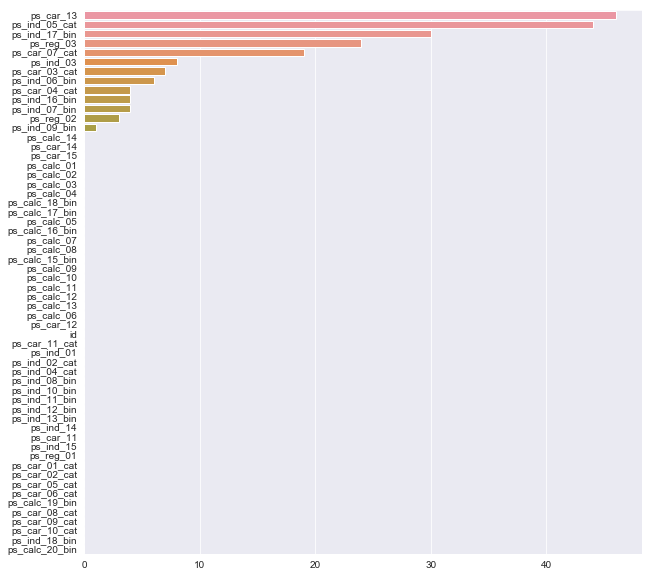

In [67]:
# 重要度の降順にプロット
ranking = np.argsort(-clf.feature_importances_)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x=clf.feature_importances_[ranking], y=xTrain.columns.values[ranking])

In [68]:
# 重要度の高いものだけ残す
xTrain = xTrain[xTrain.columns.values[ranking[:5]]]

In [69]:
xTrain.head()

,ps_car_13,ps_ind_05_cat,ps_ind_17_bin,ps_reg_03,ps_car_07_cat
0,0.883679,0,1,0.718070,1
1,0.618817,0,0,0.766078,1
2,0.641586,0,0,-1.000000,1
3,0.542949,0,0,0.580948,1
4,0.565832,0,0,0.840759,1


C:\Users\Kizashi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


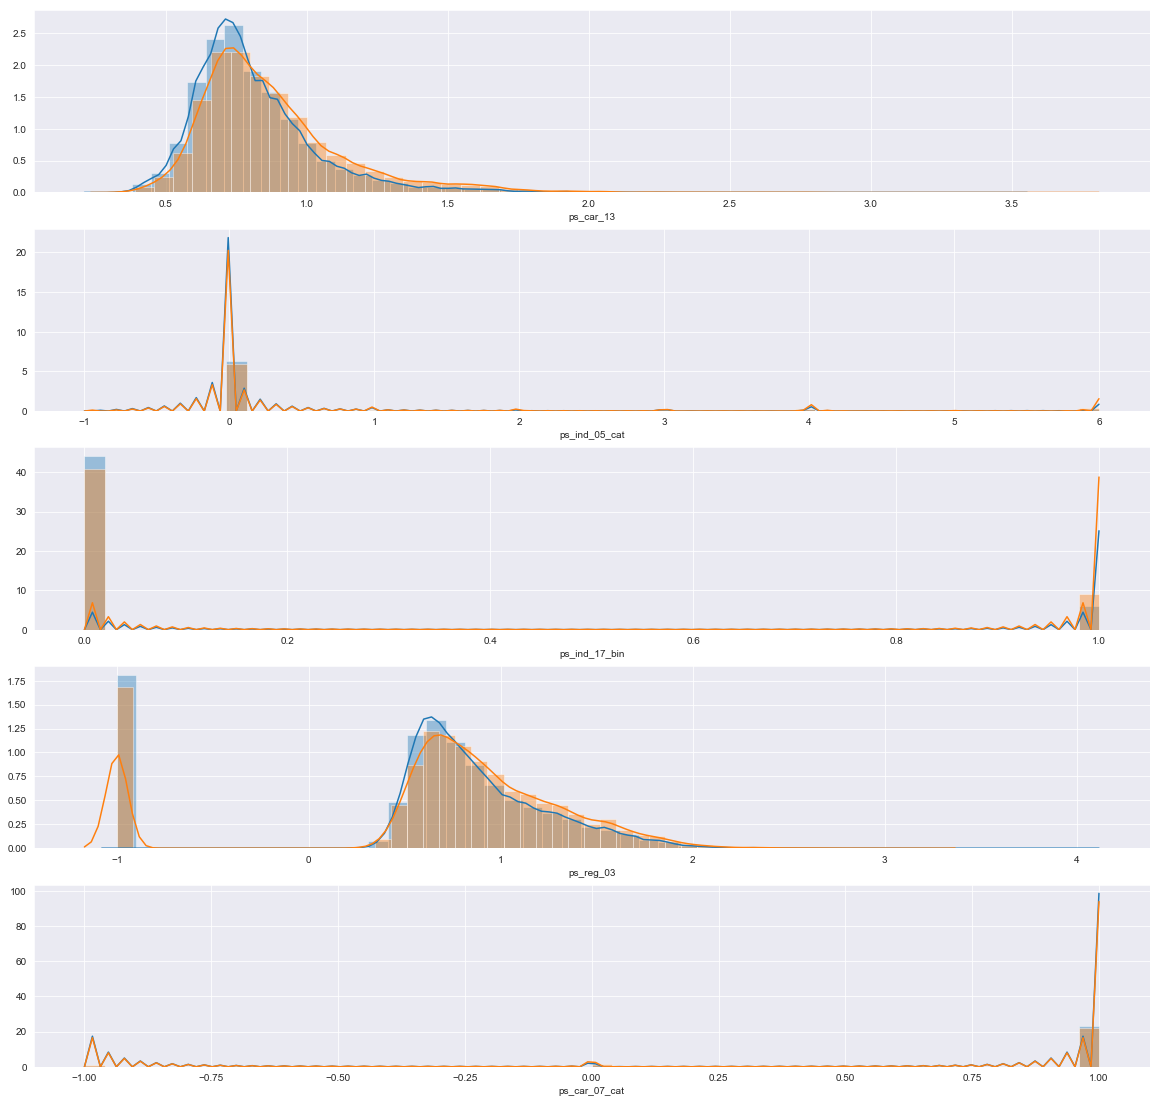

In [76]:
plt.figure(figsize=(20, 32*4))
gs = gridspec.GridSpec(32, 1)

for i, col in enumerate(df[xTrain.columns]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[col][df['target']==0], bins=50)
    sns.distplot(df[col][df['target']==1], bins=50)

In [78]:
for col in xTrain.columns.values:
    print(col)
    print(xTrain[xTrain[col]==-1])
    print('----')

ps_car_13
Empty DataFrame
Columns: [ps_car_13, ps_ind_05_cat, ps_ind_17_bin, ps_reg_03, ps_car_07_cat]
Index: []
----
ps_ind_05_cat
        ps_car_13  ps_ind_05_cat  ps_ind_17_bin  ps_reg_03  ps_car_07_cat
152      0.676464             -1              0   0.671286             -1
188      0.774823             -1              0   0.631467             -1
218      0.718685             -1              0   0.594243             -1
249      1.065616             -1              1   0.473682             -1
609      0.808784             -1              0  -1.000000             -1
659      0.633663             -1              0   1.355544             -1
721      0.905618             -1              0   0.599479             -1
778      0.625475             -1              1   0.920937             -1
847      2.055264             -1              0  -1.000000             -1
898      1.125200             -1              1   0.643720             -1
921      0.755884             -1              1  -1.00

In [82]:
df = df.replace(-1, np.nan)

In [83]:
df.dropna(how='any')

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
7,22,0,5,1.0,4,0.0,0.0,1,0,0,...,7,1,3,6,1,0,1,0,1,0
9,28,1,1,1.0,2,0.0,0.0,0,1,0,...,3,5,0,6,0,1,0,0,1,0
13,43,0,1,1.0,3,1.0,0.0,0,1,0,...,2,0,4,3,0,0,1,0,1,0
17,58,0,5,1.0,6,0.0,1.0,1,0,0,...,9,1,3,9,0,1,1,0,0,0
22,72,0,5,3.0,6,1.0,3.0,0,1,0,...,8,1,3,5,0,0,0,0,0,1
34,96,0,0,1.0,1,1.0,0.0,0,1,0,...,3,2,6,8,0,1,0,0,0,0
45,117,0,1,1.0,6,1.0,3.0,0,0,1,...,4,1,4,6,1,1,0,0,0,0
48,121,0,2,1.0,6,0.0,0.0,1,0,0,...,7,1,2,3,0,0,1,0,0,0
50,125,0,3,1.0,2,1.0,0.0,0,1,0,...,7,2,5,6,0,0,1,0,1,0
